In [2]:
# NOTEBOOK SETTINGS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))
display(HTML("<style>table {float:left}</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
%config Completer.use_jedi = False

<img src="Alpha Data.png" style="width: 300px;"/>

<center><b>ALPHA DATA<b/><center/>

# Main Trends in the Beer Market
#### By Guia, Fatih, and Leo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pgeocode
import geopandas as gpd
import mapclassify as mc
import geoplot
import descartes
from shapely.geometry import Point, Polygon
from mpl_toolkits.mplot3d import Axes3D

### Load and Merge Data From Database A

In [5]:
# MAIN SALES TABLE A

sales1 = pd.read_csv('./Dataset A/table_VENTAS_IMP_PART1.csv')
sales2 = pd.read_csv('./Dataset A/table_VENTAS_IMP_PART2 .csv')
sales = sales1.append(sales2, ignore_index=True)
sales['ID'] = range(len(sales)) # Create sales ID in the case that multiple promotions apply to the same product in the same week to later be able to group by each observation

# IMPORT / MERGE DICTIONARY

store_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Stores', header=0)
week_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Time_Periods', header=0)
product_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Products', header=0)
province_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Provinces', header=0)
channel_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Channels', header=0)

# Adding Latitude and Longitude Info
nomi = pgeocode.Nominatim('es')

longitudes = []
latitudes = []
for code in store_codes['postal_code']:
    if len(str(code)) == 4:
        code = '0' + str(code)
    elif len(str(code)) == 3:
        code = str(code) + '00'
    longitudes.append(nomi.query_postal_code(str(code))['longitude'])
    latitudes.append(nomi.query_postal_code(str(code))['latitude'])
store_codes['longitude'] = longitudes
store_codes['latitude'] = latitudes
store_codes.loc[store_codes.postal_code==28000,'latitude'] = 40.4165
store_codes.loc[store_codes.postal_code==28000,'longitude'] = -3.7046

sales_df = sales.merge(store_codes, on=['cod_tienda'], how='left')
sales_df = sales_df.merge(week_codes, on=['cod_semana'], how='left')
sales_df = sales_df.merge(product_codes, on=['cod_producto'], how='left')
sales_df = sales_df.merge(province_codes, on=['cod_provincia'], how='left')
sales_df = sales_df.merge(channel_codes, on=['cod_canal'], how='left')


# IMPORT / MERGE PROMOTIONS

with open("./Dataset A/promotions_cleaned.csv", "w") as file:
    
    with open('./Dataset A/table_PROMOCIONES_IMP.csv', 'r') as promos:
        for line in promos.readlines()[1:]:
            line = line.replace('"','')
            line = line.replace('Promo','Promo ')
            line = line.replace(';','')
            file.write(line)

promotions = pd.read_csv('./Dataset A/promotions_cleaned.csv', sep=',', header=0, 
                         dtype={'cod_tienda':'object','cod_producto':'object'})
promotions = promotions[promotions['cod_tienda']!='expositor1']
promotions['cod_tienda'] = pd.to_numeric(promotions['cod_tienda'])
promotions['cod_producto'] = pd.to_numeric(promotions['cod_producto'])
promotions = promotions.dropna()
sales_df = sales_df.merge(promotions, on=['cod_tienda','cod_semana','cod_producto'], how='left')
sales_df['promocion'] = sales_df['promocion'].fillna('No Promo')


# IMPORT / MERGE PROJECTIONS

projections = pd.read_csv('./Dataset A/table_PROYECCIONES_IMP.csv', sep=';', header=1)
projections = projections.dropna()
sales_df = sales_df.merge(projections, on=['cod_tienda','cod_semana'], how='left')


# FORMATTING

sales_df = sales_df.sort_values('Date').reset_index(drop=True)
sales_df.columns = ['store_code','week_code','product_code','sales_units','sales_value','sales_volume','referencies',
                    'real_price_units','real_price_volume','rate_price_units','rate_price_volume','ID','channel_code',
                    'province_code','postal_code','sales_surface_sqmeters','longitude','latitude','date','period',
                    'category','segment','manufacturer','brand','packaging','volume','units','province','comunidad',
                    'canal','channel','promotion','extrapolation_factor']

sales_df = sales_df.drop(['channel_code','province_code','canal','category', 'referencies'],1)


sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482714 entries, 0 to 6482713
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_code              int64         
 1   week_code               int64         
 2   product_code            int64         
 3   sales_units             int64         
 4   sales_value             float64       
 5   sales_volume            int64         
 6   real_price_units        float64       
 7   real_price_volume       float64       
 8   rate_price_units        float64       
 9   rate_price_volume       float64       
 10  ID                      int32         
 11  postal_code             int64         
 12  sales_surface_sqmeters  int64         
 13  longitude               float64       
 14  latitude                float64       
 15  date                    datetime64[ns]
 16  period                  object        
 17  segment                 object        
 18  ma

#### Creating Column Corresponding to Sales Value Multiplied by Extrapolation Factor to Get Sales for all of Spain

In [6]:
sales_df['sales'] = sales_df.sales_value * sales_df.extrapolation_factor

#### Taking Care of Missing Values

In [7]:
# Number of missing values
sales_df.isna().sum()[sales_df.isna().sum()>0]

longitude               192129
latitude                192129
extrapolation_factor       681
sales                      681
dtype: int64

The longitude and latitude missing values stem from postal codes that have been recorded wrongly and do not exist in Spain. In this case, this applies for 5 stores. Therefore, these stores will have to be excluded from the analysis as it is unclear where they exist in Spain.

In [8]:
x = sales_df.groupby(['store_code']).agg({'longitude': lambda x: x.isna().sum(), 'postal_code':'mean'})
x[x['longitude']>0]

,longitude,postal_code
store_code,,
228,53768.0,13012
264,46911.0,9973
281,12679.0,0
461,41430.0,12477
491,37341.0,11463


In [9]:
sales_df2 = sales_df.dropna(subset=['latitude','longitude'])

Imputing Extrapolation Factor

In [10]:
x = sales_df2.groupby(['store_code','week_code']).agg({'extrapolation_factor': lambda x: x.isna().sum()})
x[x['extrapolation_factor']>0]

extrapolation_factor
store_code week_code                      
3          1                          93.0
           2                          84.0
           3                         107.0
           4                          96.0
           5                         101.0
           6                          92.0
556        1                          70.0
557        125                        38.0

As can be seen the extrapolation factor is only missing for 3 different stores and for a few weeks. This can be imputed by replacing the missing values with the values of the next row as it follows a time series.

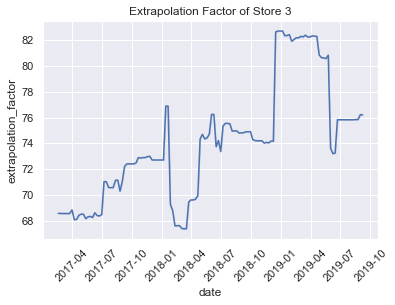

In [11]:
sns.set()
sns.lineplot(data=sales_df2[sales_df2.store_code==3], x='date', y='extrapolation_factor')
plt.title('Extrapolation Factor of Store 3')
plt.xticks(rotation=45);

In [12]:
sales_df3 = sales_df2.fillna(axis=0, method='bfill')

In [13]:
sales_df3.isna().sum()

store_code                0
week_code                 0
product_code              0
sales_units               0
sales_value               0
sales_volume              0
real_price_units          0
real_price_volume         0
rate_price_units          0
rate_price_volume         0
ID                        0
postal_code               0
sales_surface_sqmeters    0
longitude                 0
latitude                  0
date                      0
period                    0
segment                   0
manufacturer              0
brand                     0
packaging                 0
volume                    0
units                     0
province                  0
comunidad                 0
channel                   0
promotion                 0
extrapolation_factor      0
sales                     0
dtype: int64

In [14]:
# Dropping duplicates created from multiple promotions
df = sales_df3.drop_duplicates(subset=['ID'])

## Beer Sales (Pre-Covid-19  Analysis)

### Total

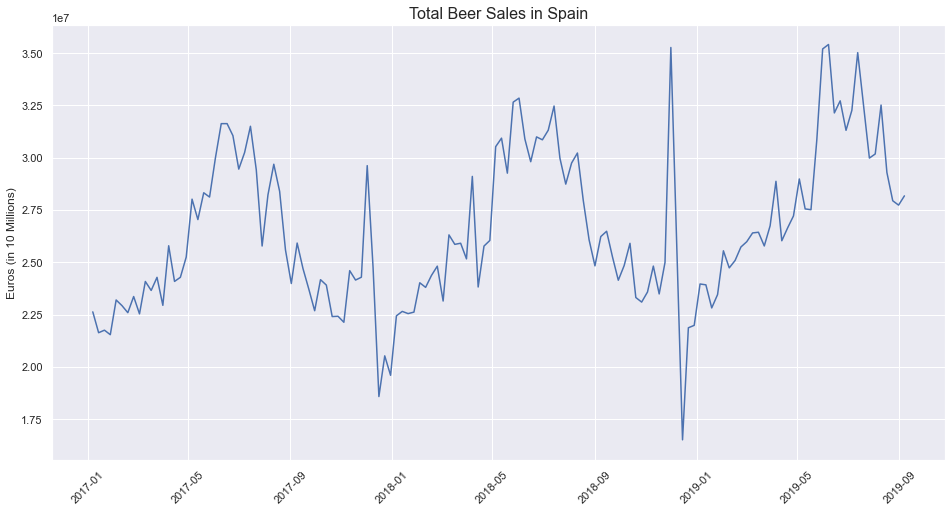

In [15]:
by_total = df.groupby('date', as_index=False).agg({'sales':'sum'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_total, x='date', y='sales')
plt.title('Total Beer Sales in Spain', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

### By Beer Segment

In [16]:
df.segment.value_counts()

NATIONAL           2051319
IMPORT PREMIUM      849084
IMPORT SPECIAL      697633
FLAVOURED           609357
EXTRA               598725
ZERO ALCOHOL        429275
WITHOUT ALCOHOL     296617
BLACK               257963
ARTISANS            164540
CELIACS             123008
Name: segment, dtype: int64

Some segments are combined such as `without alcohol` and `zero alcohol` or `imported premium` and `imported special`.

In [17]:
segment_df = df.copy()
segment_df.segment = segment_df.segment.replace({'ZERO ALCOHOL':'WITHOUT ALCOHOL'})
segment_df.segment = segment_df.segment.replace({'IMPORT SPECIAL':'IMPORT PREMIUM'})
segment_df.segment = segment_df.segment.replace({'WITHOUT ALCOHOL':'NON-ALCOHOLIC'})
segment_df.segment = segment_df.segment.replace({'IMPORT PREMIUM':'IMPORTED'})
by_avg_segment = segment_df.groupby(['date','segment'], as_index=False).agg({'sales':'sum'}).groupby(['segment'], as_index=False).agg({'sales':'mean'})

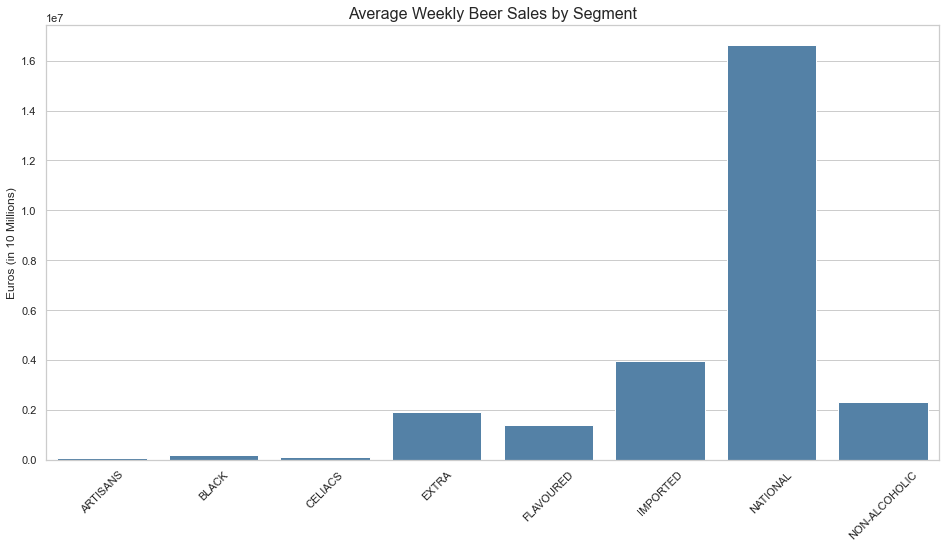

In [18]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_segment, x='segment', y='sales', color='steelblue')
plt.title('Average Weekly Beer Sales by Segment', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

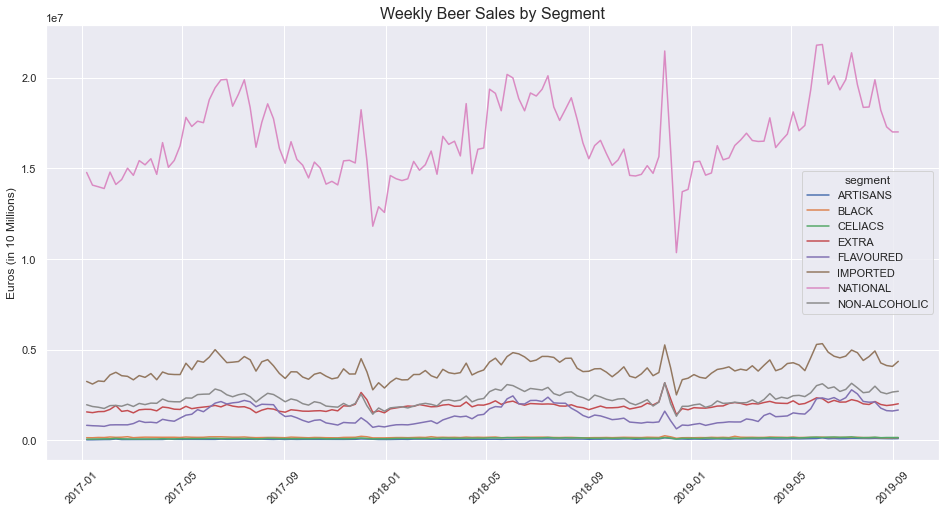

In [19]:
by_segment = segment_df.groupby(['date','segment'], as_index=False).agg({'sales':'sum'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_segment, x='date', y='sales', hue='segment')
plt.title('Weekly Beer Sales by Segment', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

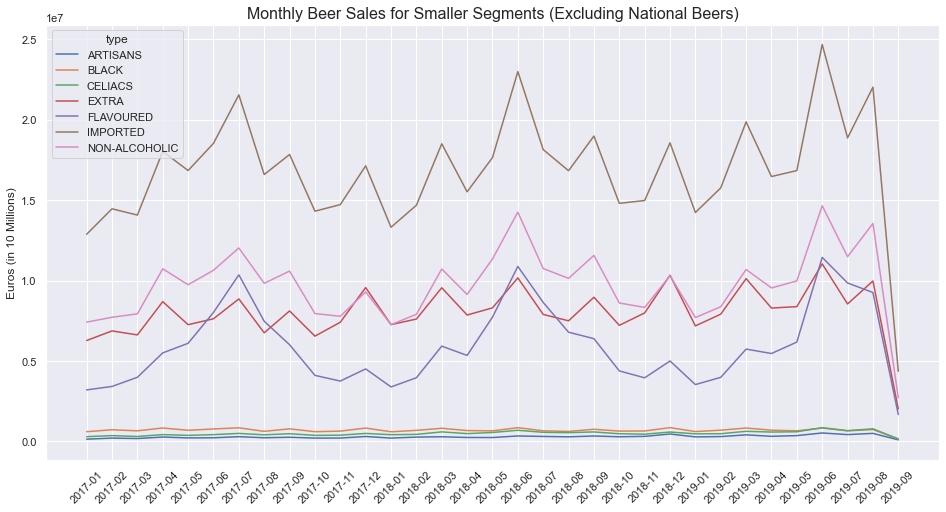

In [20]:
by_segment = segment_df.groupby(['date','segment'], as_index=False).agg({'sales':'sum'})
by_segment = by_segment.groupby([by_segment.date.dt.to_period('M'),'segment']).agg({'sales':'sum'})
by_segment = by_segment[by_segment.index.get_level_values(1)!='NATIONAL']
by_segment['month'] = by_segment.index.get_level_values(0).astype('string')
by_segment['type'] = by_segment.index.get_level_values(1)

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_segment, x='month', y='sales', hue='type')
plt.title('Monthly Beer Sales for Smaller Segments (Excluding National Beers)', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

Compared to other beer segments, flavoured beers gain a lot of popularity in summer, especially June.

#### What Beer Segments are Trending?

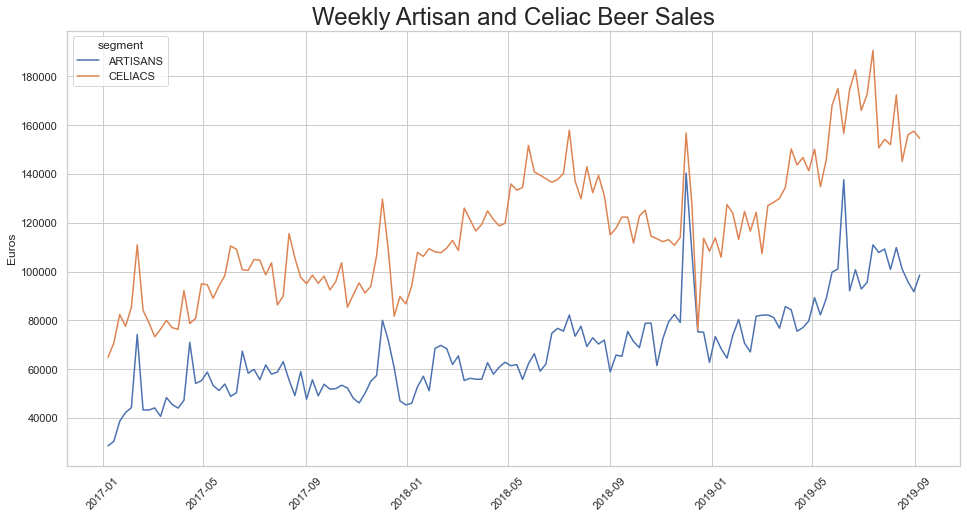

In [24]:
by_segment = segment_df.groupby(['date','segment'], as_index=False).agg({'sales':'sum'})
by_segment = by_segment[(by_segment.segment=='ARTISANS')|(by_segment.segment=='CELIACS')]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_segment, x='date', y='sales', hue='segment')
plt.title('Weekly Artisan and Celiac Beer Sales', fontsize=24)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [27]:
segment_df.segment.unique()

array(['NATIONAL', 'FLAVOURED', 'NON-ALCOHOLIC', 'CELIACS', 'EXTRA',
       'IMPORTED', 'BLACK', 'ARTISANS'], dtype=object)

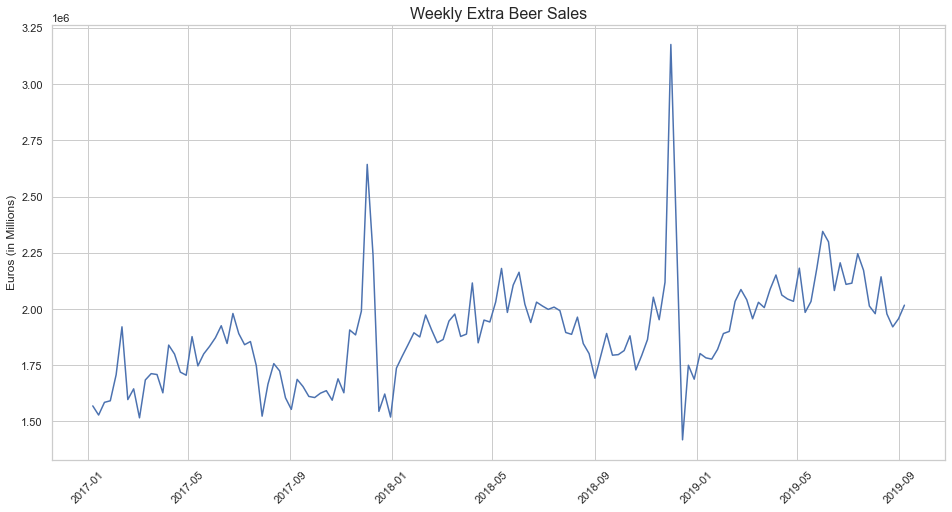

In [32]:
by_segment = segment_df.groupby(['date','segment'], as_index=False).agg({'sales':'sum'})
by_segment = by_segment[by_segment.segment=='EXTRA']

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_segment, x='date', y='sales')
plt.title('Weekly Extra Beer Sales', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

#### Where are certain types of beer more popular?

In [100]:
def observations(x):
    return len(x)

def national_percent(x):
    count = x.value_counts()
    if 'NATIONAL' in count.index:
        return count['NATIONAL'] * 100 / len(x)
    else: return 0 

def import_percent(x):
    count = x.value_counts()
    if 'IMPORTED' in count.index:
        return count['IMPORTED'] * 100 / len(x)
    else: return 0
    
def no_alc_percent(x):
    count = x.value_counts()
    if 'NON-ALCOHOLIC' in count.index:
        return count['NON-ALCOHOLIC'] * 100 / len(x)
    else: return 0
    
def artisan_percent(x):
    count = x.value_counts()
    if 'ARTISANS' in count.index:
        return count['ARTISANS'] * 100 / len(x)
    else: return 0



by_loc_seg = segment_df.groupby(['store_code'], as_index=False).agg(
    observations=('ID',observations),
    latitude=('latitude','mean'),
    longitude=('longitude','mean'),
    national_beers=('segment',national_percent),
    imported_beers=('segment',import_percent),
    non_alc_beers=('segment',no_alc_percent),
    artisan_beers=('segment',artisan_percent)
)

by_loc_seg = by_loc_seg[by_loc_seg['observations'] > 10].reset_index(drop=True)

by_loc_seg.head()

,store_code,observations,latitude,longitude,national_beers,imported_beers,non_alc_beers,artisan_beers
0,1,789,36.8381,-2.4597,43.346008,16.476553,17.363752,0.000000
1,3,13378,43.4647,-3.8044,33.996113,18.283749,13.088653,2.421887
2,4,32899,43.2627,-2.9253,25.900483,34.089182,10.498799,5.276756
3,5,5429,39.8770,-0.0143,44.520169,21.421993,17.645975,0.000000
4,6,3744,41.2871,-4.6888,46.741453,16.319444,13.942308,0.000000


In [78]:
spain_map = gpd.read_file('spain_shapefile/natalidad.geojson')
geometry = [Point(xy) for xy in zip(by_loc_seg.longitude, by_loc_seg.latitude)]

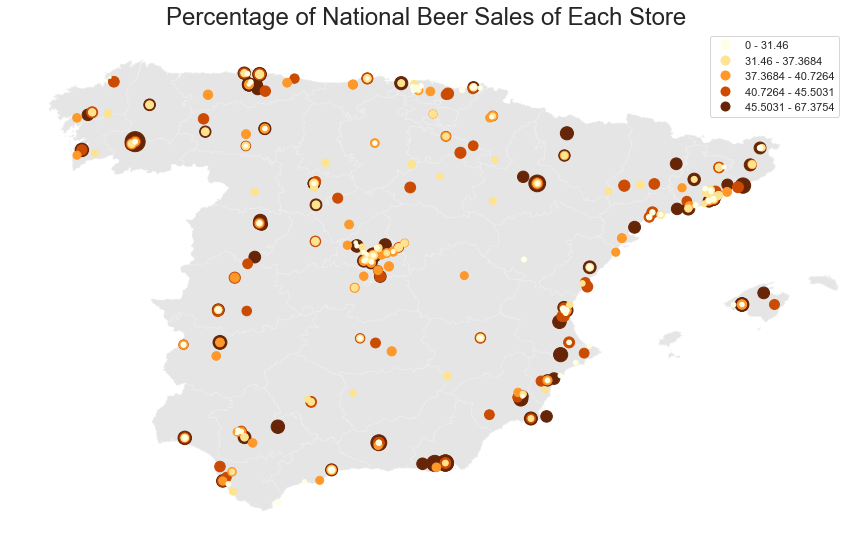

In [150]:
geo_df = gpd.GeoDataFrame(by_loc_seg['national_beers'],crs={'init':'epsg:4326'},geometry=geometry)

scheme = mc.Quantiles(geo_df['national_beers'], k=5)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
ax.axis([-10, 4, 36, 44])
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geoplot.pointplot(geo_df, ax=ax, hue='national_beers', legend=True, legend_var='hue', scheme=scheme, scale='national_beers', limits=(1, 20), cmap='YlOrBr')
plt.title('Percentage of National Beer Sales of Each Store', fontsize=24);

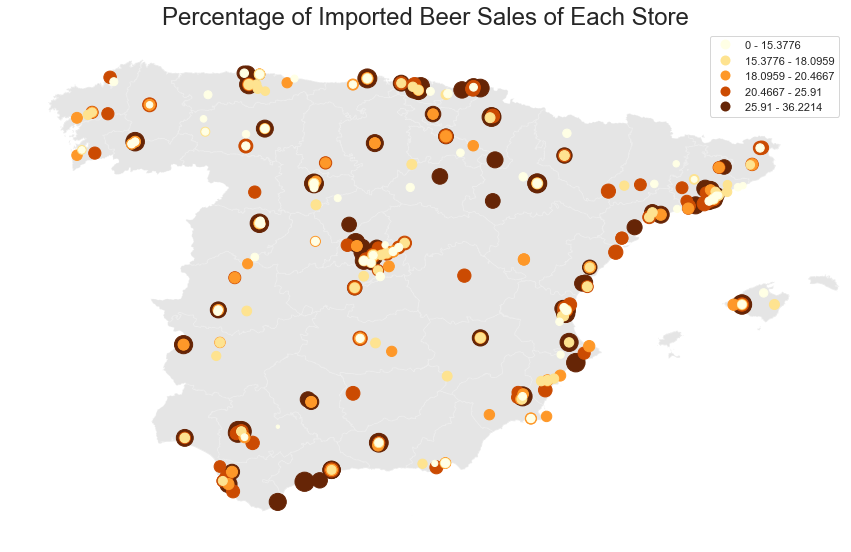

In [169]:
geo_df = gpd.GeoDataFrame(by_loc_seg['imported_beers'],crs={'init':'epsg:4326'},geometry=geometry)

scheme = mc.Quantiles(geo_df['imported_beers'], k=5)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geoplot.pointplot(geo_df, ax=ax, hue='imported_beers', legend=True, legend_var='hue', scheme=scheme, scale='imported_beers', limits=(1, 20), cmap='YlOrBr')
plt.title('Percentage of Imported Beer Sales of Each Store', fontsize=24);

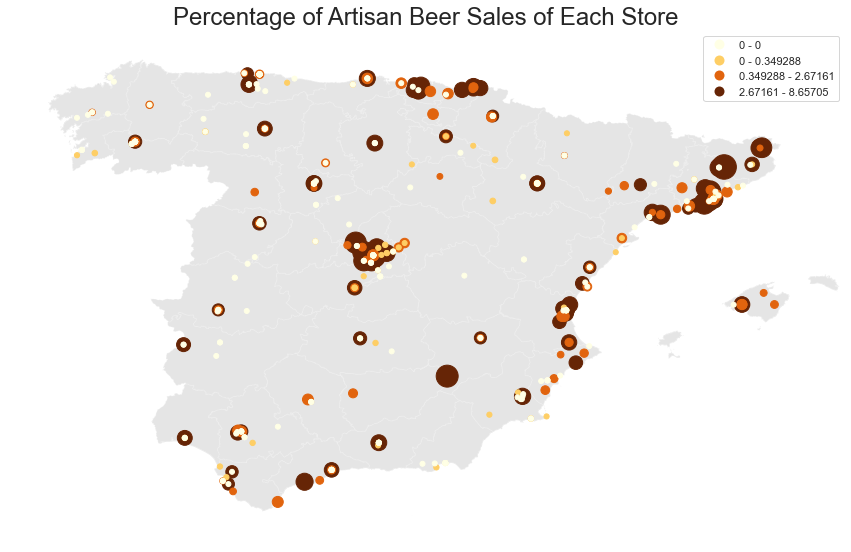

In [153]:
geo_df = gpd.GeoDataFrame(by_loc_seg['artisan_beers'],crs={'init':'epsg:4326'},geometry=geometry)

scheme = mc.Quantiles(geo_df['artisan_beers'], k=5)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geoplot.pointplot(geo_df, ax=ax, hue='artisan_beers', legend=True, legend_var='hue', scheme=scheme, scale='artisan_beers', limits=(5, 25), cmap='YlOrBr')
plt.title('Percentage of Artisan Beer Sales of Each Store', fontsize=24);

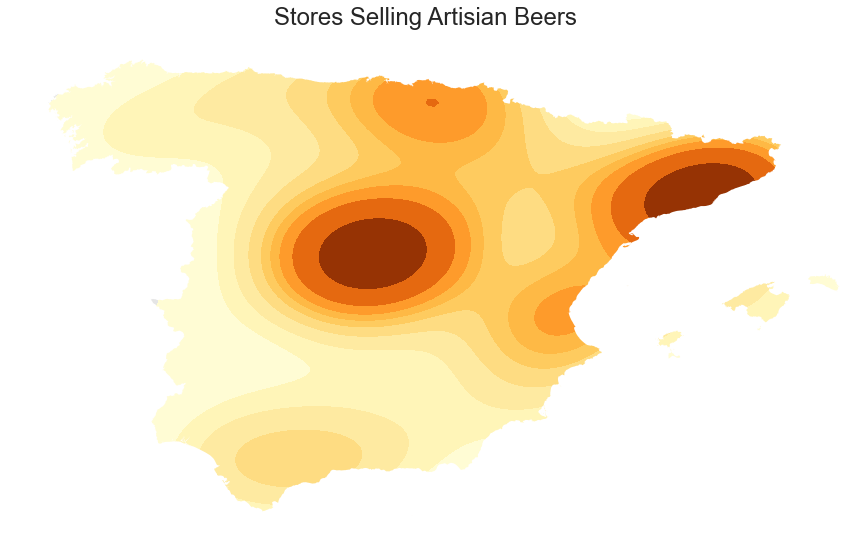

In [175]:
geometry = [Point(xy) for xy in zip(by_loc_seg[by_loc_seg['artisan_beers']>0].longitude, by_loc_seg[by_loc_seg['artisan_beers']>0].latitude)]
geo_df = gpd.GeoDataFrame(by_loc_seg[by_loc_seg['artisan_beers']>0]['artisan_beers'],crs={'init':'epsg:4326'},geometry=geometry)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geoplot.kdeplot(geo_df, ax=ax, cmap='YlOrBr', shade=True, clip=spain_map, shade_lowest=False)
plt.title('Stores Selling Artisian Beers', fontsize=24);

### By Manufacturer / Brand

What is the most trending brand/manufacturer producing most? What segment etc.

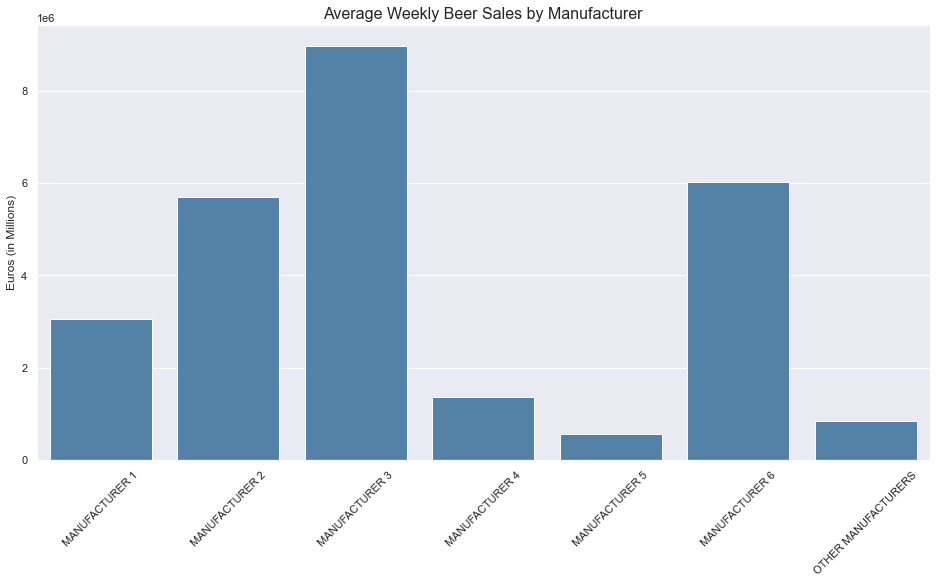

In [104]:
by_avg_man = df.groupby(['date','manufacturer'], as_index=False).agg({'sales':'sum'}).groupby(['manufacturer'], as_index=False).agg({'sales':'mean'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_man, x='manufacturer', y='sales', color='steelblue')
plt.title('Average Weekly Beer Sales by Manufacturer', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

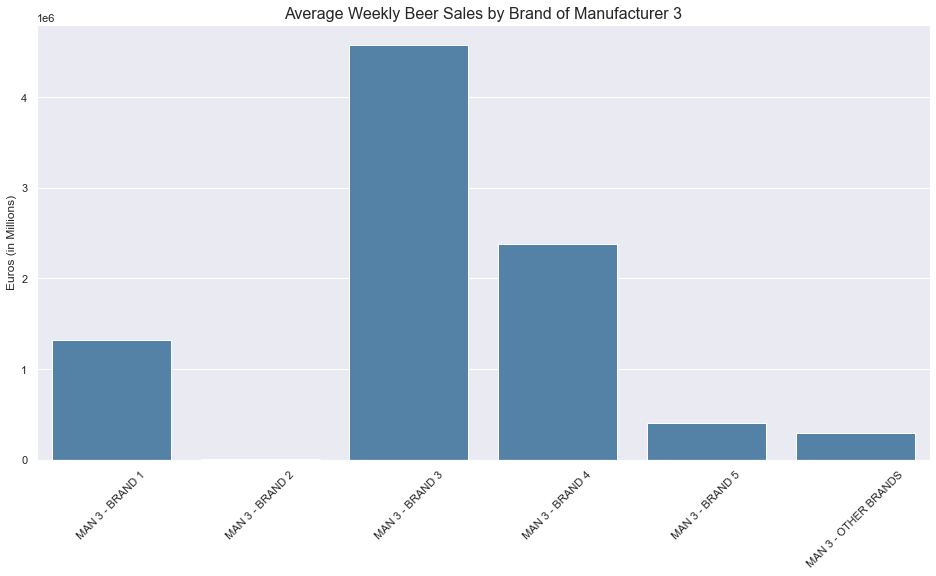

In [106]:
by_avg_brand = df[df.manufacturer=='MANUFACTURER 3'].groupby(['date','brand'], as_index=False).agg({'sales':'sum'}).groupby(['brand'], as_index=False).agg({'sales':'mean'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_brand, x='brand', y='sales', color='steelblue')
plt.title('Average Weekly Beer Sales by Brand of Manufacturer 3', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

#### Most Trending Brands By Segment

In [34]:
trending2 = df.groupby(['week_code','brand','segment'], as_index=False).agg({'sales':'sum'})
weeks = df.groupby(['brand','segment'], as_index=False).agg(MIN=('week_code','min'), MAX=('week_code','max'))

weeks = weeks[(weeks.MIN==1)&(weeks.MAX==140)][['brand','segment']].to_records(index=False)
trending2 = trending2[trending2[['brand', 'segment']].apply(tuple, axis=1).isin(weeks)]
trending2 = trending2[(trending2.week_code==1)|(trending2.week_code==140)]

trending3 = trending2[trending2['week_code']==140]
early_trending = trending2[trending2['week_code']==1]

trending3['percent_increase'] = (trending3.sales.values - early_trending.sales.values) * 100 / trending3.sales.values

trending3 = trending3.sort_values('percent_increase', ascending=False).reset_index(drop=True).drop(['week_code','sales'], 1)
trending3.head()

,brand,segment,percent_increase
0,MAN 3 - BRAND 3,EXTRA,98.897171
1,MAN 4 - BRAND 1,FLAVOURED,80.009087
2,MAN 6 - BRAND 1,IMPORT SPECIAL,73.229797
3,MAN 5 - BRAND 2,ARTISANS,72.671596
4,MAN 2 - BRAND 1,FLAVOURED,68.604079


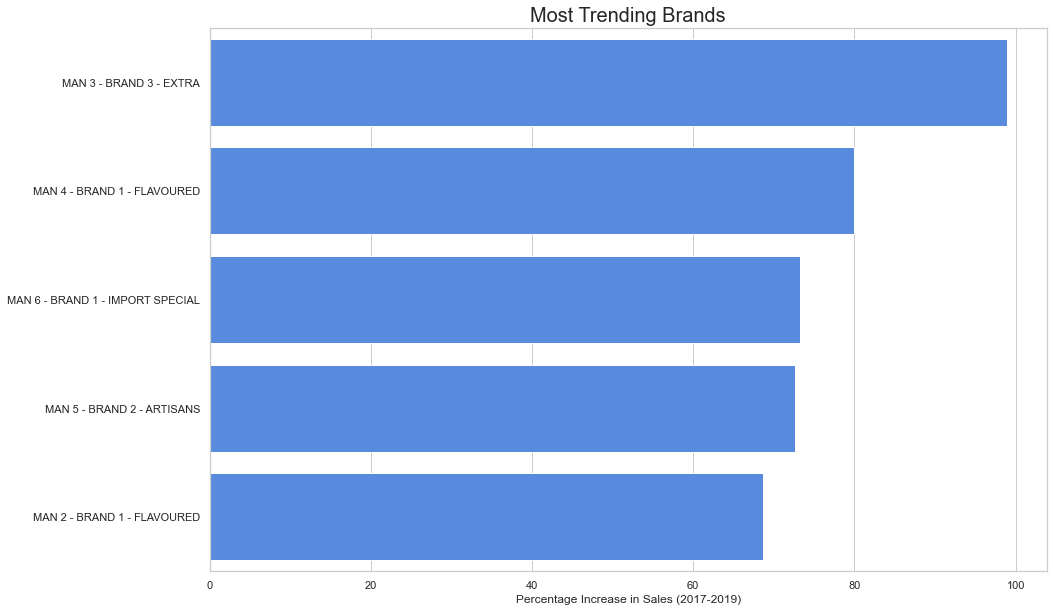

In [36]:
trending3['product'] = trending3.brand + ' - ' + trending3.segment

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=trending3.head(5), x='percent_increase', y='product', color='#4285f4')
plt.xlabel('Percentage Increase in Sales (2017-2019)')
plt.ylabel('')
plt.title('Most Trending Brands', fontsize=20);

In [33]:
trending_brands = trending3.drop(['product','percent_increase'],1).head(1).to_records(index=False)
trending_brands

rec.array([('MAN 3 - BRAND 3', 'EXTRA')],
          dtype=[('brand', 'O'), ('segment', 'O')])

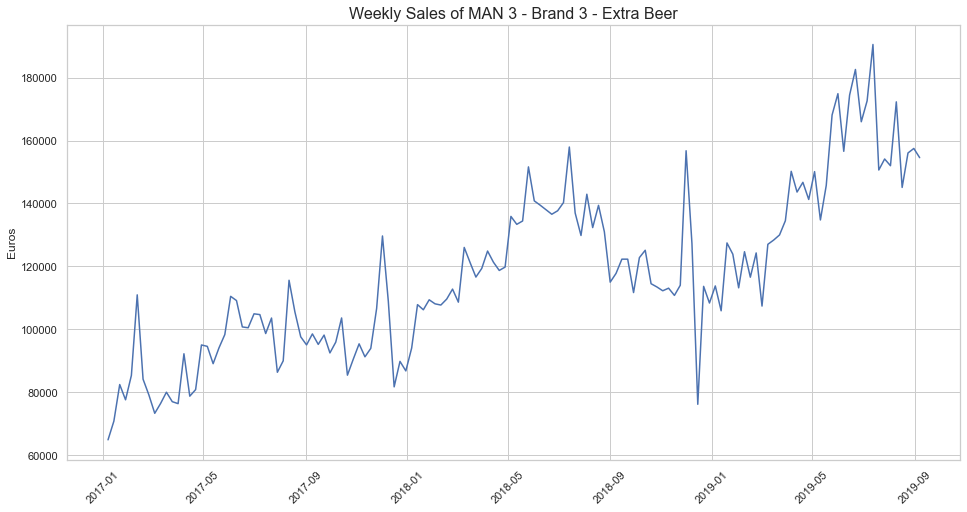

In [34]:
by_brand_segment = df.groupby(['date','brand','segment'], as_index=False).agg({'sales':'sum'})
by_brand_segment = by_brand_segment[by_brand_segment[['brand', 'segment']].apply(tuple, axis=1).isin(trending_brands)]
by_brand_segment['product'] = by_brand_segment.brand + ' - ' + by_brand_segment.segment

sns.set_style('whitegrid')
# g = sns.FacetGrid(data=by_brand_segment, row='product', sharey=False, aspect=5)
# g = g.map(sns.lineplot,'date','sales');

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_segment, x='date', y='sales')
plt.title('Weekly Sales of MAN 3 - Brand 3 - Extra Beer', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [128]:
# Key characteristics of MAN 3 - Brand 3 - Extra Beer
df[(df.brand=='MAN 3 - BRAND 3')&(df.segment=='EXTRA')].head()

,store_code,week_code,product_code,sales_units,sales_value,sales_volume,real_price_units,real_price_volume,rate_price_units,rate_price_volume,...,brand,packaging,volume,units,province,comunidad,channel,promotion,extrapolation_factor,sales
383,380,1,275,1,11.25,3,11.25,2.64,11.25,2.64,...,MAN 3 - BRAND 3,CRISTAL BOTTLE,330ML,8CT,Valladolid,Castilla y León,Hipermarkets,No Promo,1.68,18.9000
4296,450,1,275,2,26.38,5,13.19,2.64,13.19,2.64,...,MAN 3 - BRAND 3,CRISTAL BOTTLE,330ML,8CT,Area Metropolitana de Madrid,Madrid,Supermarkets,No Promo,1.55,40.8890
5388,506,1,275,2,26.38,5,13.19,2.64,13.19,2.64,...,MAN 3 - BRAND 3,CRISTAL BOTTLE,330ML,8CT,Area Metropolitana de Barcelona,Cataluña,Hipermarkets,No Promo,1.87,49.3306
5875,507,1,275,1,13.19,3,13.19,2.64,13.19,2.64,...,MAN 3 - BRAND 3,CRISTAL BOTTLE,330ML,8CT,Valencia,Comunidad Valenciana,Hipermarkets,No Promo,2.20,29.0180
21645,190,1,275,2,23.98,5,11.99,2.64,11.99,2.64,...,MAN 3 - BRAND 3,CRISTAL BOTTLE,330ML,8CT,Caceres,Extremadura,Supermarkets,No Promo,27.20,652.2560


#### Main Characteristics of Most Trending Beer
- Sold in 330ML Cristal Bottle or 330ML Can

### Packaging

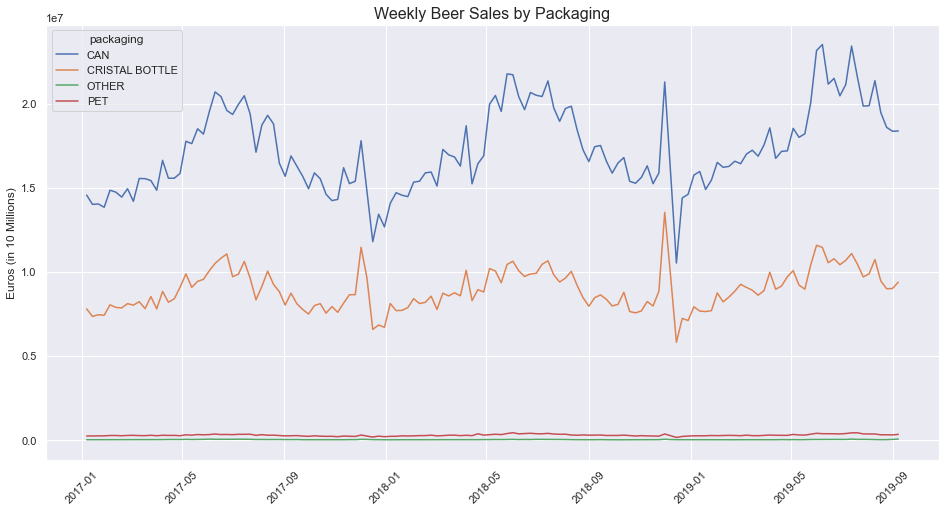

In [129]:
by_pack = df.groupby(['date','packaging'], as_index=False).agg({'sales':'sum'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack, x='date', y='sales', hue='packaging')
plt.title('Weekly Beer Sales by Packaging', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

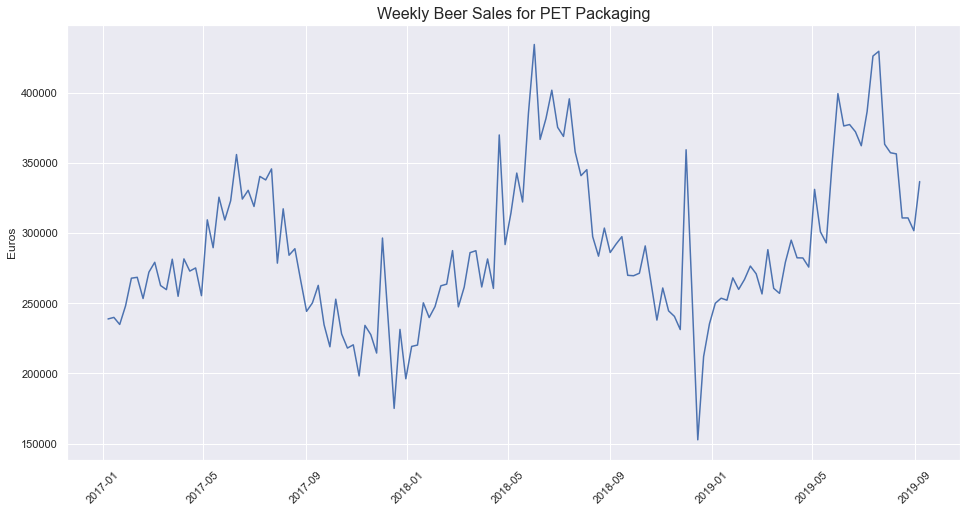

In [140]:
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.packaging=='PET')], x='date', y='sales')
plt.title('Weekly Beer Sales for PET Packaging', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

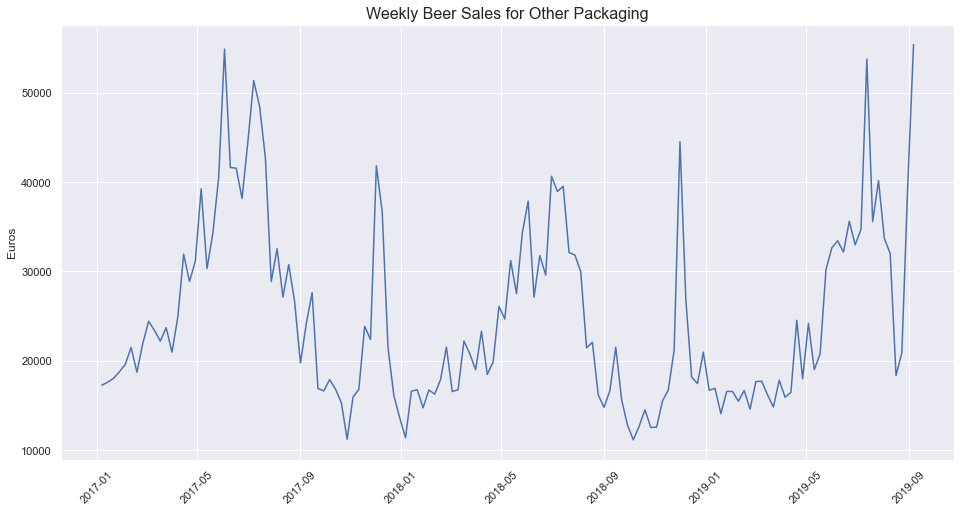

In [141]:
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.packaging=='OTHER')], x='date', y='sales')
plt.title('Weekly Beer Sales for Other Packaging', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

#### Percentage Increases

In [135]:
trending_pack1 = df.groupby(['week_code','packaging'], as_index=False).agg({'sales':'sum'})

trending_pack = trending_pack1[trending_pack1['week_code']==140]
early_trending_pack = trending_pack1[trending_pack1['week_code']==1]

trending_pack['percent_increase'] = (trending_pack.sales.values - early_trending_pack.sales.values) * 100 / trending_pack.sales.values

trending_pack = trending_pack.sort_values('percent_increase', ascending=False).reset_index(drop=True).drop(['week_code','sales'], 1)
trending_pack.head()

,packaging,percent_increase
0,OTHER,68.830246
1,PET,29.069147
2,CAN,20.754938
3,CRISTAL BOTTLE,16.942429


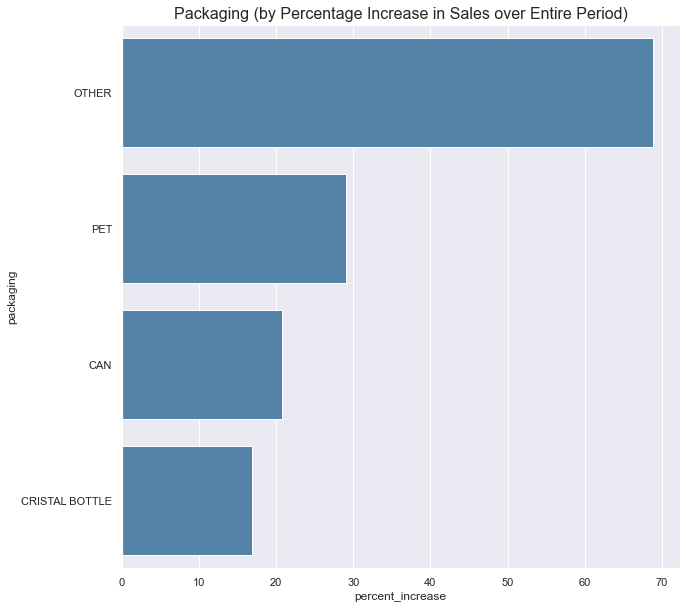

In [137]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=trending_pack, x='percent_increase', y='packaging', color='steelblue')
plt.title('Packaging (by Percentage Increase in Sales over Entire Period)', fontsize=16);

### Promotions 

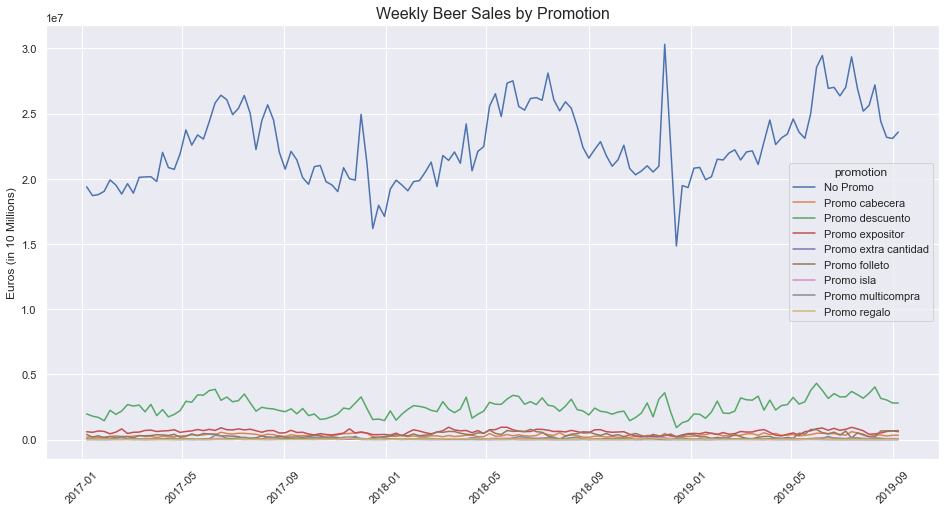

In [22]:
by_promo = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo, x='date', y='sales', hue='promotion')
plt.title('Weekly Beer Sales by Promotion', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

In [ ]:
by_brand = df.groupby(['date','brand','promotion'], as_index=False).agg({'sales':'sum'})
by_brand = by_brand[(by_brand.promotion=='Promo folleto')|
                    (by_brand.promotion=='Promo cabecera')|
                    (by_brand.promotion=='Promo descuento')|
                    (by_brand.promotion=='Promo expositor')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_brand[(by_brand.brand=='MAN 3 - BRAND 3')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Brand Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [ ]:
by_brand = df.groupby(['date','brand','promotion'], as_index=False).agg({'sales':'sum'})
by_brand = by_brand[(by_brand.promotion=='Promo cabecera')|
                            (by_brand.promotion=='Promo expositor')|
                            (by_brand.promotion=='Promo folleto')|
                            (by_brand.promotion=='Promo isla')|
                            (by_brand.promotion=='Promo multicompra')|
                            (by_brand.promotion=='Promo regalo')|
                            (by_brand.promotion=='Promo descuento')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_brand[(by_brand.brand=='MAN 3 - BRAND 3')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Brand Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

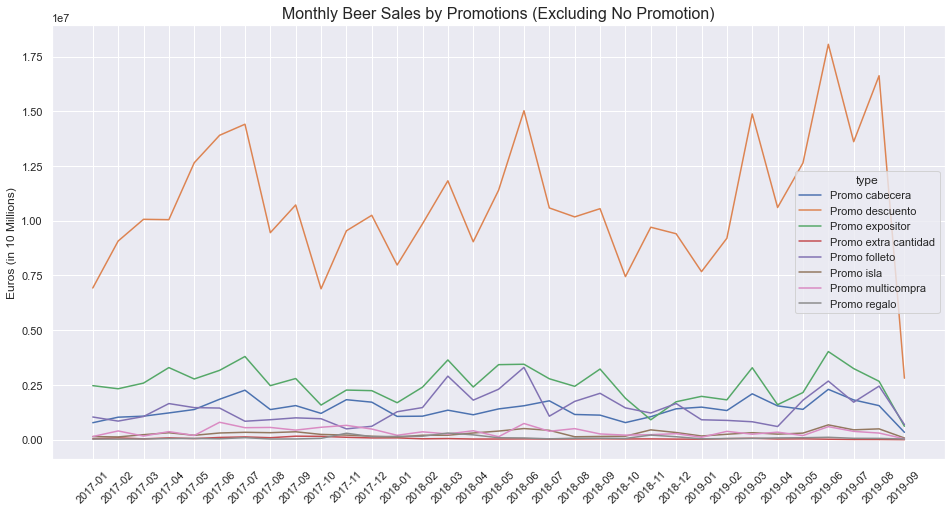

In [23]:
by_promo1 = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})
by_promo1 = by_promo1.groupby([by_promo1.date.dt.to_period('M'),'promotion']).agg({'sales':'sum'})
by_promo1 = by_promo1[by_promo1.index.get_level_values(1)!='No Promo']
by_promo1['month'] = by_promo1.index.get_level_values(0).astype('string')
by_promo1['type'] = by_promo1.index.get_level_values(1)

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo1, x='month', y='sales', hue='type')
plt.title('Monthly Beer Sales by Promotions (Excluding No Promotion)', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

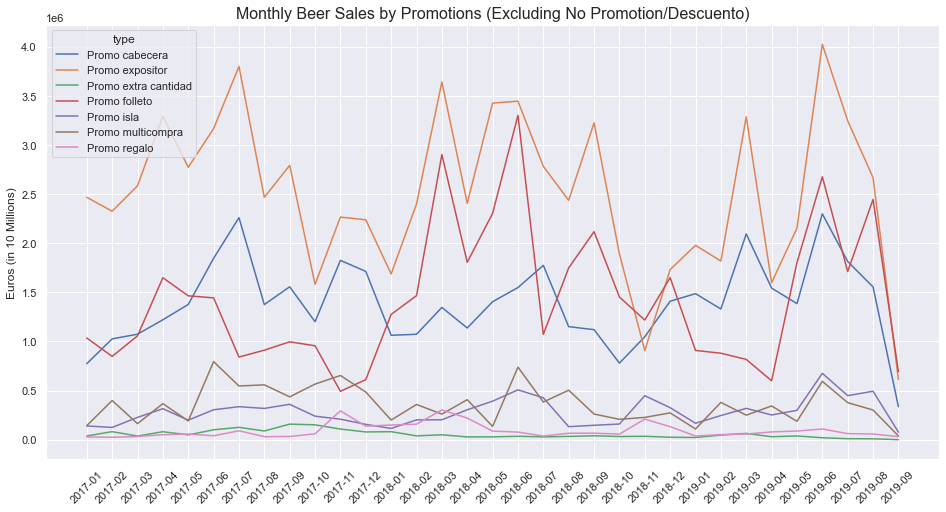

In [24]:
by_promo1 = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})
by_promo1 = by_promo1.groupby([by_promo1.date.dt.to_period('M'),'promotion']).agg({'sales':'sum'})
by_promo1 = by_promo1[by_promo1.index.get_level_values(1)!='No Promo']
by_promo1 = by_promo1[by_promo1.index.get_level_values(1)!='Promo descuento']
by_promo1['month'] = by_promo1.index.get_level_values(0).astype('string')
by_promo1['type'] = by_promo1.index.get_level_values(1)

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo1, x='month', y='sales', hue='type')
plt.title('Monthly Beer Sales by Promotions (Excluding No Promotion/Descuento)', fontsize=16)
plt.ylabel('Euros (in 10 Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

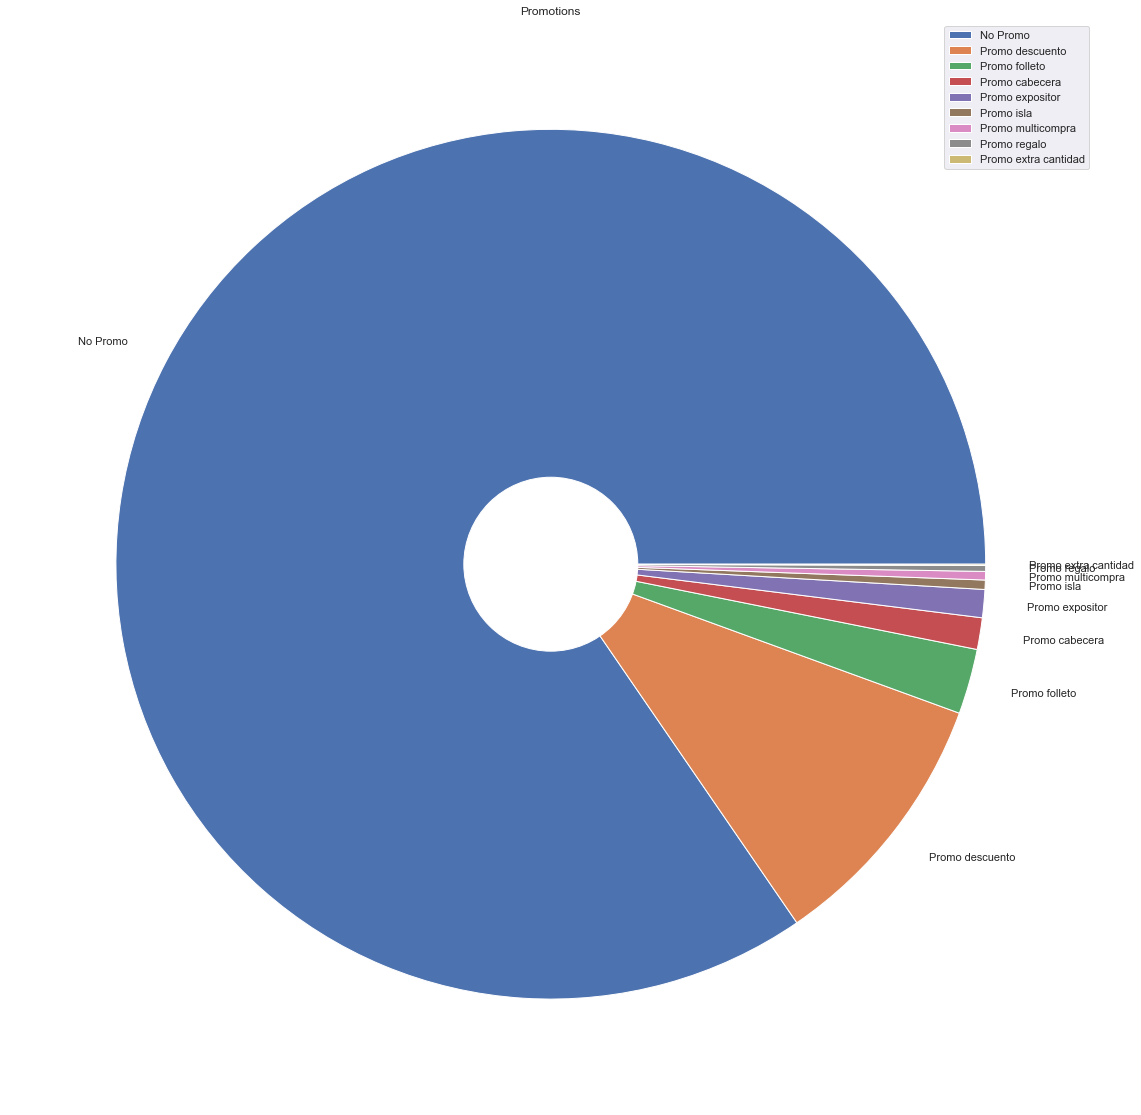

In [25]:
promo = sales_df["promotion"].value_counts()

# Risize the figure 
plt.figure(figsize=(100,20))

# Plot the graph
circle = plt.Circle((0,0),0.2,color = "white")
plt.pie(promo.values, labels = promo.index)
pl = plt.gcf()
pl.gca().add_artist(circle) 
plt.title("Promotions")
plt.legend()
plt.xticks(rotation = 15)

# Display the graph
plt.show()

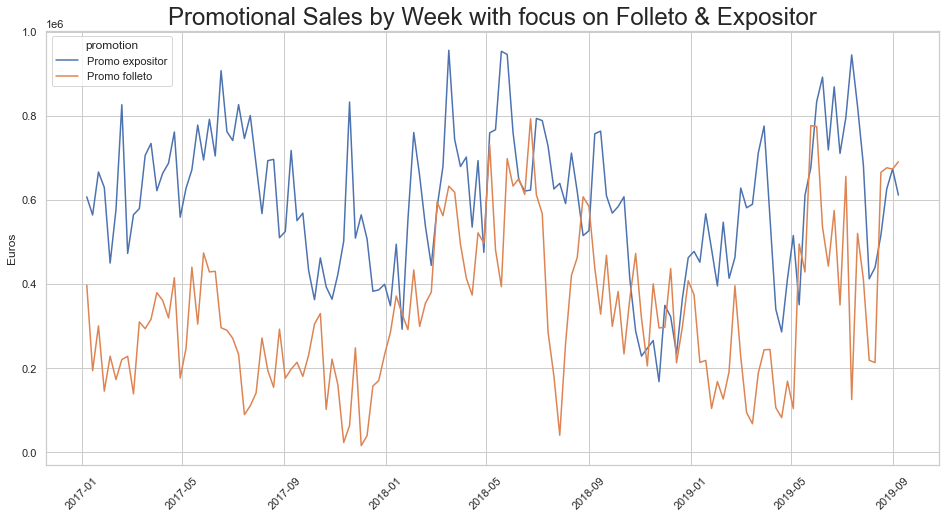

In [26]:
by_promo = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})
by_promo = by_promo[(by_promo.promotion=='Promo folleto')|(by_promo.promotion=='Promo expositor')]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo, x='date', y='sales', hue='promotion')
plt.title('Promotional Sales by Week with focus on Folleto & Expositor', fontsize=24)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

#### Promotion Strategy for Artisans and Celiacs

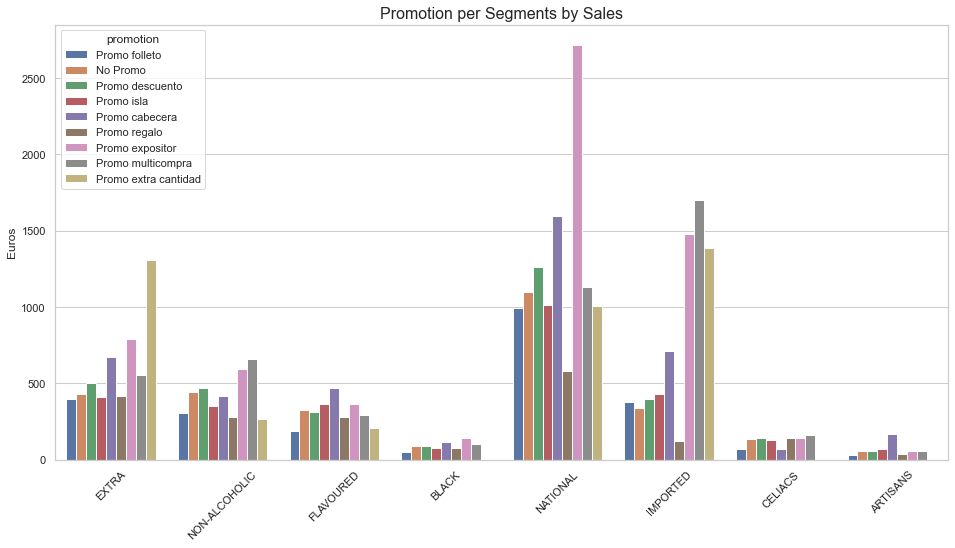

In [30]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=segment_df, x='segment', y='sales', hue='promotion',ci=None)
plt.title('Promotion per Segments by Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [31]:
trending2 = df.groupby(['week_code','promotion','segment'], as_index=False).agg({'sales':'sum'})
weeks = df.groupby(['promotion','segment'], as_index=False).agg(MIN=('week_code','min'), MAX=('week_code','max'))

weeks = weeks[(weeks.MIN==1)&(weeks.MAX==140)][['promotion','segment']].to_records(index=False)
trending2 = trending2[trending2[['promotion', 'segment']].apply(tuple, axis=1).isin(weeks)]
trending2 = trending2[(trending2.week_code==1)|(trending2.week_code==140)]

trending3 = trending2[trending2['week_code']==140]
early_trending = trending2[trending2['week_code']==1]

trending3['percent_increase'] = (trending3.sales.values - early_trending.sales.values) * 100 / trending3.sales.values

trending3 = trending3.sort_values('percent_increase', ascending=False).reset_index(drop=True).drop(['week_code','sales'], 1)
trending3.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,promotion,segment,percent_increase
0,Promo folleto,WITHOUT ALCOHOL,99.768624
1,Promo cabecera,WITHOUT ALCOHOL,99.563575
2,Promo regalo,NATIONAL,99.329205
3,Promo folleto,EXTRA,98.702313
4,Promo multicompra,EXTRA,97.394635


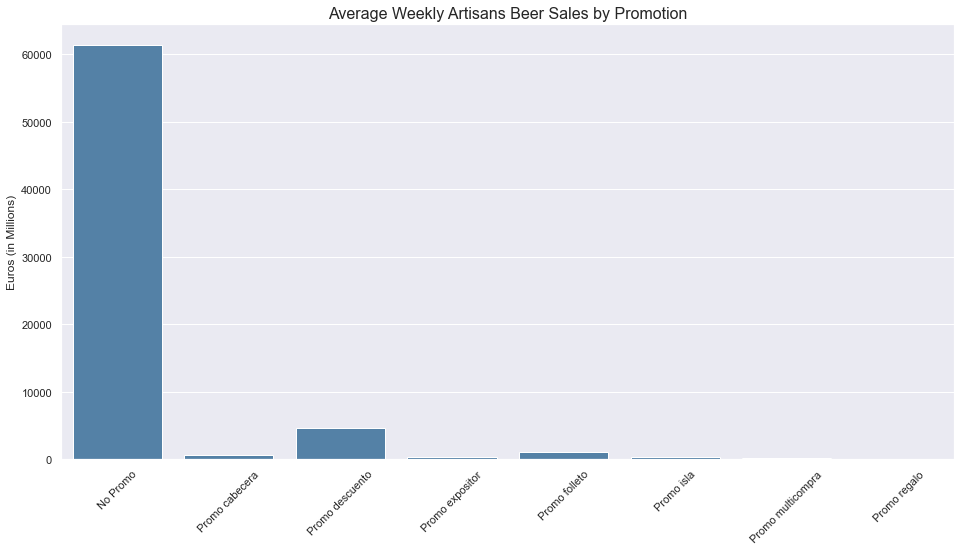

In [32]:
by_avg_brand = df[df.segment=='ARTISANS'].groupby(['date','promotion'], as_index=False).agg({'sales':'sum'}).groupby(['promotion'], as_index=False).agg({'sales':'mean'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_brand, x='promotion', y='sales', color='steelblue')
plt.title('Average Weekly Artisans Beer Sales by Promotion', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

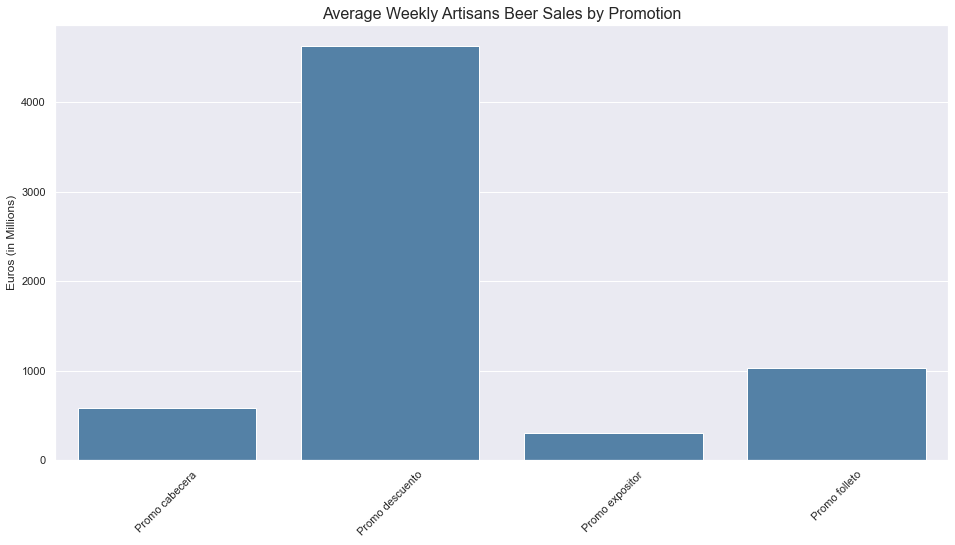

In [33]:
by_avg_brand = df[df.segment=='ARTISANS'].groupby(['date','promotion'], as_index=False).agg({'sales':'sum'}).groupby(['promotion'], as_index=False).agg({'sales':'mean'})
by_avg_brand = by_avg_brand[(by_avg_brand.promotion=='Promo cabecera')|
                            (by_avg_brand.promotion=='Promo expositor')|
                            (by_avg_brand.promotion=='Promo folleto')|
                            (by_avg_brand.promotion=='Promo descuento')]


sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_brand, x='promotion', y='sales', color='steelblue')
plt.title('Average Weekly Artisans Beer Sales by Promotion', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

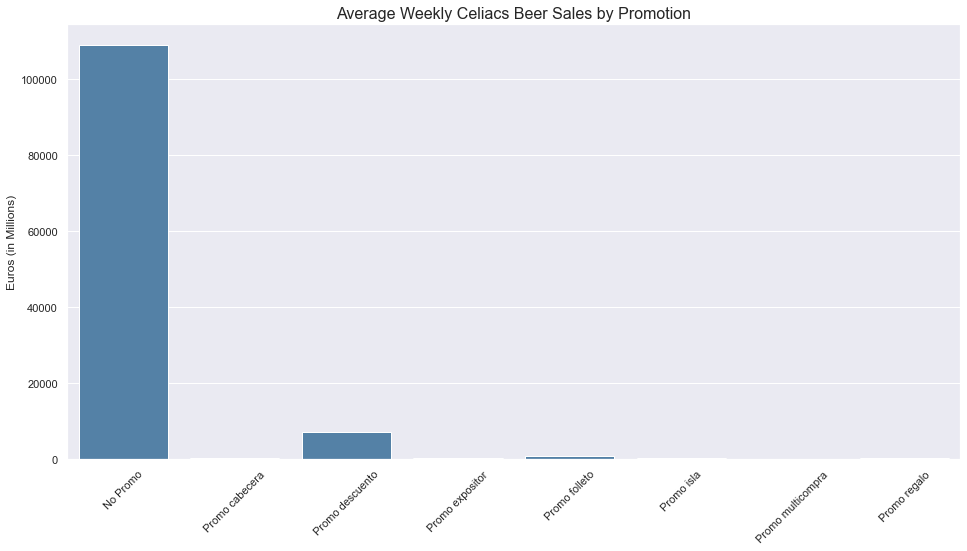

In [34]:
by_avg_brand = df[df.segment=='CELIACS'].groupby(['date','promotion'], as_index=False).agg({'sales':'sum'}).groupby(['promotion'], as_index=False).agg({'sales':'mean'})

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_brand, x='promotion', y='sales', color='steelblue')
plt.title('Average Weekly Celiacs Beer Sales by Promotion', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

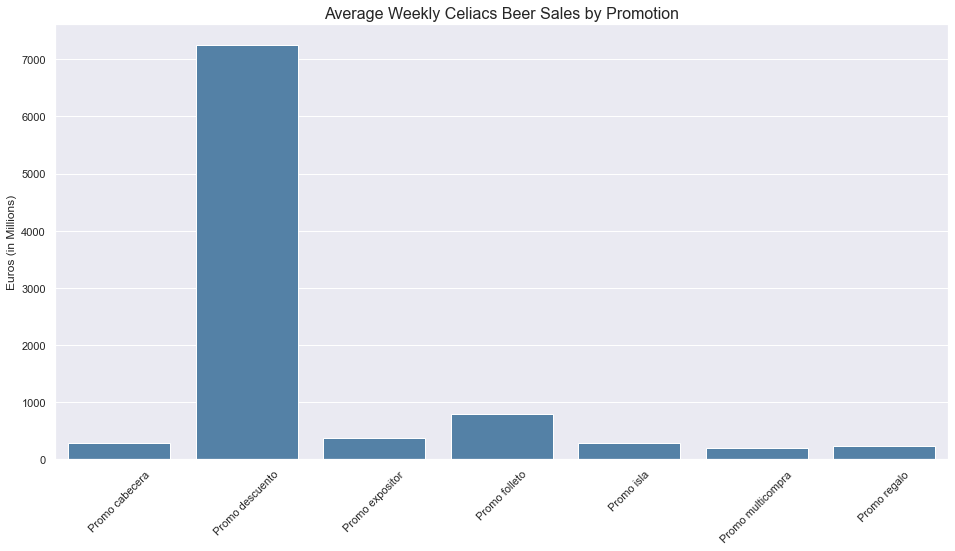

In [35]:
by_avg_brand = df[df.segment=='CELIACS'].groupby(['date','promotion'], as_index=False).agg({'sales':'sum'}).groupby(['promotion'], as_index=False).agg({'sales':'mean'})
by_avg_brand = by_avg_brand[(by_avg_brand.promotion=='Promo cabecera')|
                            (by_avg_brand.promotion=='Promo expositor')|
                            (by_avg_brand.promotion=='Promo folleto')|
                            (by_avg_brand.promotion=='Promo isla')|
                            (by_avg_brand.promotion=='Promo multicompra')|
                            (by_avg_brand.promotion=='Promo regalo')|
                            (by_avg_brand.promotion=='Promo descuento')]


sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=by_avg_brand, x='promotion', y='sales', color='steelblue')
plt.title('Average Weekly Celiacs Beer Sales by Promotion', fontsize=16)
plt.ylabel('Euros (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45);

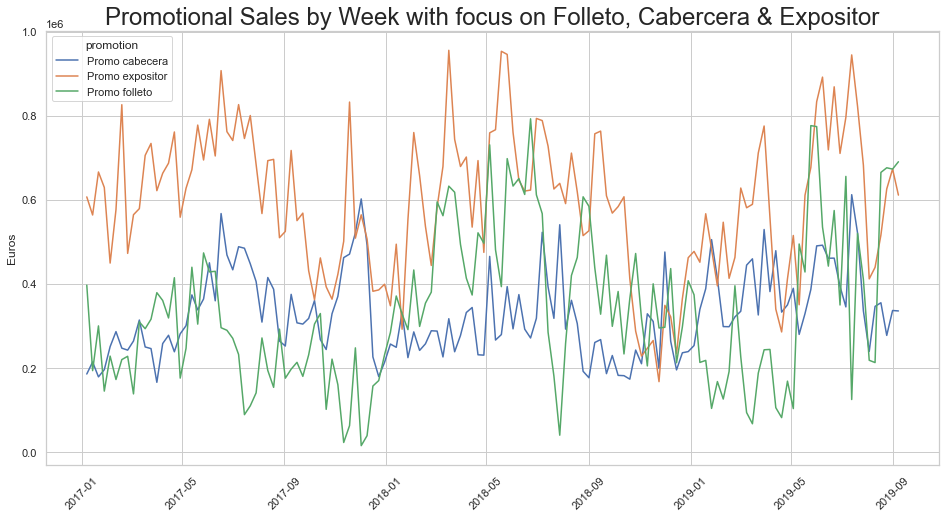

In [36]:
by_promo = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})
by_promo = by_promo[(by_promo.promotion=='Promo folleto')|
                    (by_promo.promotion=='Promo cabecera')|
                    (by_promo.promotion=='Promo expositor')]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo, x='date', y='sales', hue='promotion')
plt.title('Promotional Sales by Week with focus on Folleto, Cabercera & Expositor', fontsize=24)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

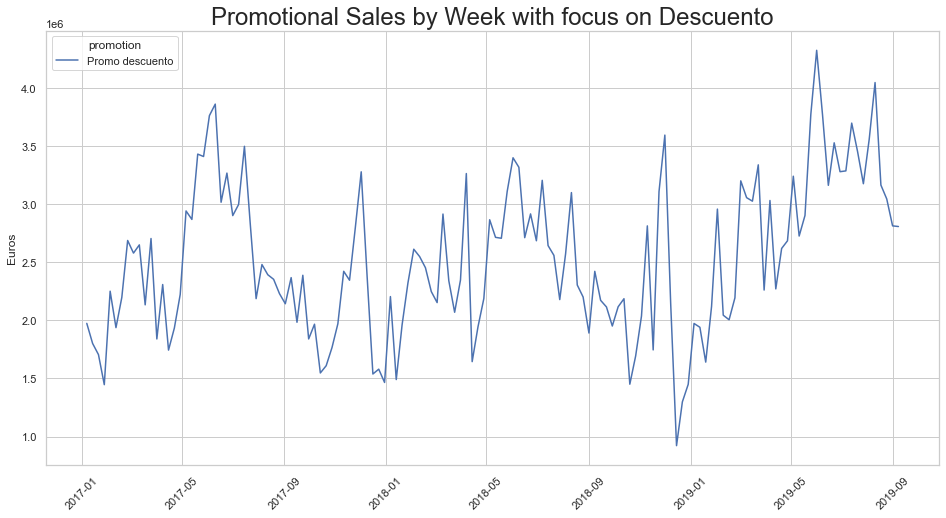

In [37]:
by_promo = df.groupby(['date','promotion'], as_index=False).agg({'sales':'sum'})
by_promo = by_promo[(by_promo.promotion=='Promo descuento')]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_promo, x='date', y='sales', hue='promotion')
plt.title('Promotional Sales by Week with focus on Descuento', fontsize=24)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

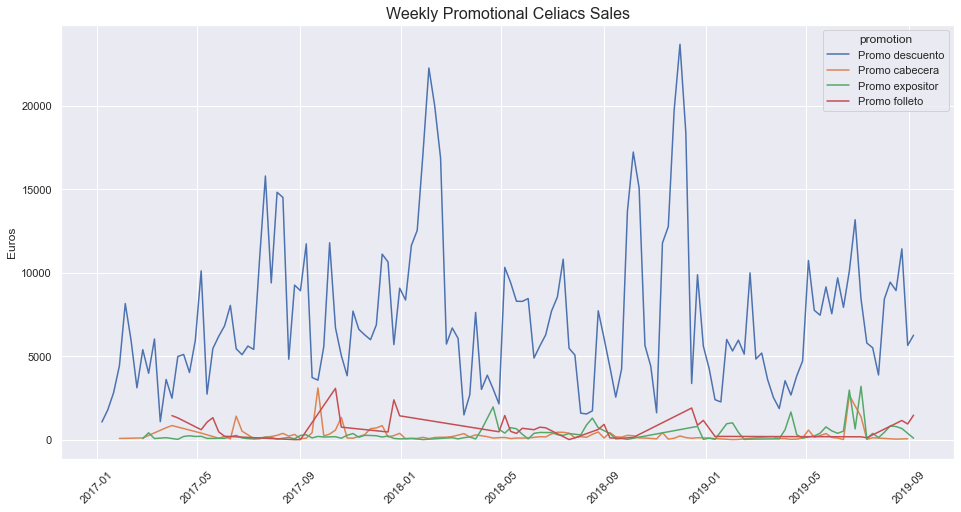

In [38]:
by_pack = df.groupby(['date','segment','promotion'], as_index=False).agg({'sales':'sum'})
by_pack = by_pack[(by_pack.promotion=='Promo folleto')|
                    (by_pack.promotion=='Promo cabecera')|
                    (by_pack.promotion=='Promo descuento')|
                    (by_pack.promotion=='Promo expositor')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.segment=='CELIACS')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Celiacs Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

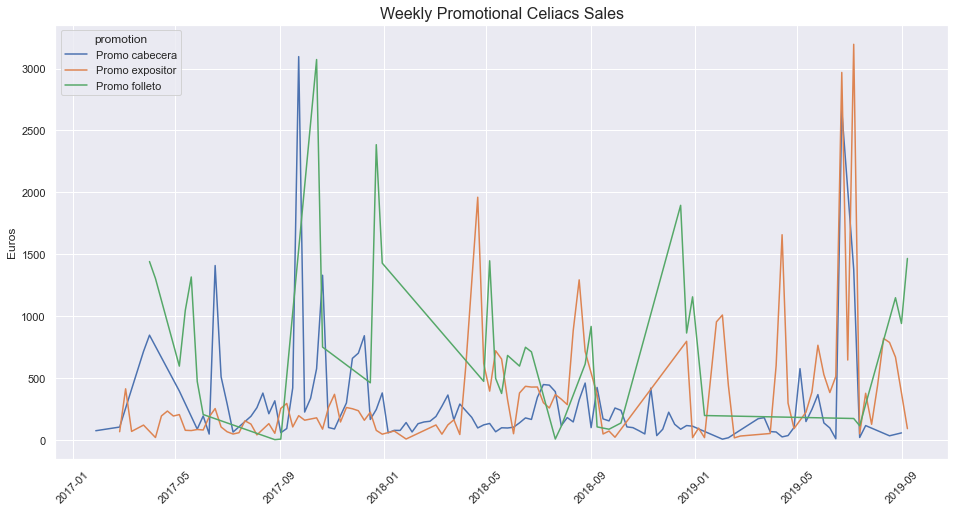

In [39]:
by_pack = df.groupby(['date','segment','promotion'], as_index=False).agg({'sales':'sum'})
by_pack = by_pack[(by_pack.promotion=='Promo folleto')|
                    (by_pack.promotion=='Promo cabecera')|
                    (by_pack.promotion=='Promo expositor')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.segment=='CELIACS')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Celiacs Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

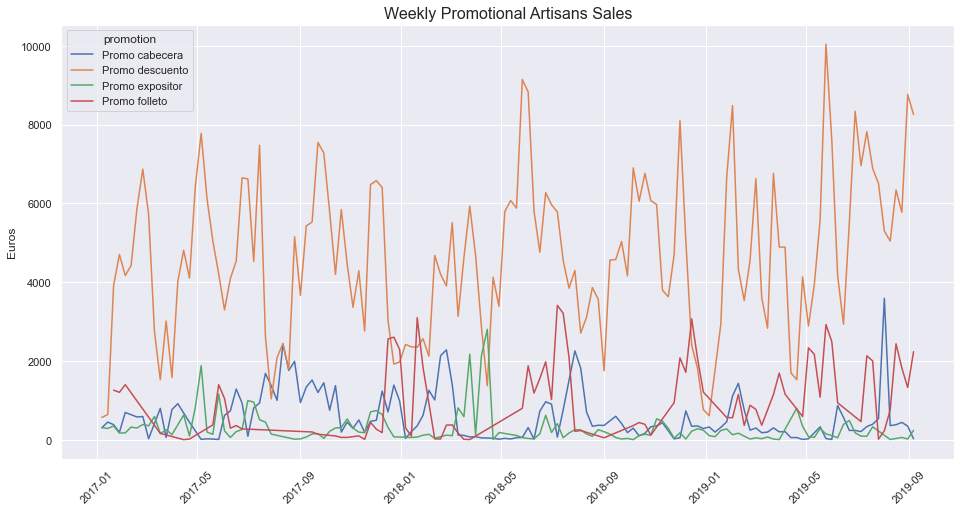

In [40]:
by_pack = df.groupby(['date','segment','promotion'], as_index=False).agg({'sales':'sum'})
by_pack = by_pack[(by_pack.promotion=='Promo folleto')|
                    (by_pack.promotion=='Promo cabecera')|
                    (by_pack.promotion=='Promo descuento')|
                    (by_pack.promotion=='Promo expositor')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.segment=='ARTISANS')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Artisans Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

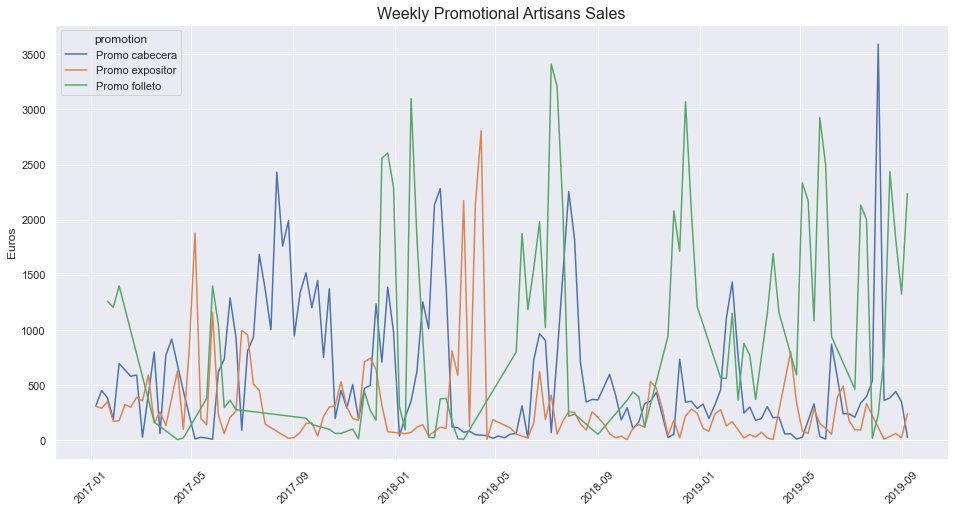

In [41]:
by_pack = df.groupby(['date','segment','promotion'], as_index=False).agg({'sales':'sum'})
by_pack = by_pack[(by_pack.promotion=='Promo folleto')|
                    (by_pack.promotion=='Promo cabecera')|
                    (by_pack.promotion=='Promo expositor')]

sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_pack[(by_pack.segment=='ARTISANS')], x='date', y='sales', hue='promotion')
plt.title('Weekly Promotional Artisans Sales', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

### Prices

In [ ]:
by_price = df.groupby(['date','brand'], as_index=False).agg({'real_price_units':'mean'})
by_price = by_price[by_price.brand=='MAN 3 - BRAND 3']

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_price, x='date', y='real_price_units')
plt.title('Weekly Brand Beer Prices', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [ ]:
by_price = df.groupby(['date','brand'], as_index=False).agg({'real_price_units':'mean'})
by_price = by_price[by_price.brand=='MAN 4 - BRAND 1']

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_price, x='date', y='real_price_units')
plt.title('Weekly Brand Beer Prices', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);

In [ ]:
by_price = df.groupby(['date','brand'], as_index=False).agg({'real_price_units':'mean'})
by_price = by_price[by_price.brand=='MAN 6 - BRAND 1']

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=by_price, x='date', y='real_price_units')
plt.title('Weekly Brand Beer Prices', fontsize=16)
plt.ylabel('Euros')
plt.xlabel('')
plt.xticks(rotation=45);